In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'

In [3]:
!ls -l /vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/

total 12466911
-rw-r--r-- 1 dw515 cms0 6854308226 Mar  1 10:33 fakes.root
-rw-r--r-- 1 dw515 cms0 2243882311 Mar  1 10:30 ggH.root
-rw-r--r-- 1 dw515 cms0 3547255399 Mar  1 10:29 VBFH.root
-rw-r--r-- 1 dw515 cms0  120669646 Mar  1 10:32 ZTT.root


In [4]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [5]:
vbfh_tree.keys()

[b'genM',
 b'genpT',
 b'gen_nu_p_1',
 b'gen_nu_p_2',
 b'gen_nu_phi_1',
 b'gen_nu_phi_2',
 b'gen_nu_eta_1',
 b'gen_nu_eta_2',
 b'gen_vis_p_1',
 b'gen_vis_p_2',
 b'gen_vis_E_1',
 b'gen_vis_E_2',
 b'gen_vis_phi_1',
 b'gen_vis_phi_2',
 b'gen_vis_eta_1',
 b'gen_vis_eta_2',
 b'pt_2',
 b'pt_1',
 b'iso_1',
 b'met',
 b'wt_cp_sm',
 b'wt_cp_ps',
 b'wt_cp_mm',
 b'mva_dm_1',
 b'mva_dm_2',
 b'tau_decay_mode_2',
 b'tau_decay_mode_1',
 b'trg_singleelectron',
 b'trg_singlemuon',
 b'trg_doubletau',
 b'deepTauVsJets_medium_1',
 b'deepTauVsJets_medium_2',
 b'deepTauVsEle_vvloose_1',
 b'deepTauVsEle_vvloose_2',
 b'deepTauVsEle_tight_1',
 b'deepTauVsEle_tight_2',
 b'deepTauVsMu_vloose_1',
 b'deepTauVsMu_vloose_2',
 b'deepTauVsMu_tight_1',
 b'deepTauVsMu_tight_2',
 b'aco_angle_1',
 b'aco_angle_2',
 b'aco_angle_3',
 b'aco_angle_4',
 b'aco_angle_5',
 b'aco_angle_6',
 b'aco_angle_7',
 b'pv_angle',
 b'mass0',
 b'mass1',
 b'mass2',
 b'ip_sig_1',
 b'ip_sig_2',
 b'rand',
 b'tauFlag_1',
 b'tauFlag_2',
 b'gen_phitt',

In [6]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [7]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [8]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [9]:
vbfh_sm = vbfh[(vbfh["rand"] < vbfh["wt_cp_sm"]/2)]
ggh_sm = ggh[(ggh["rand"] < ggh["wt_cp_sm"]/2)]

In [10]:
vbfh_sm.loc[:, 'y'] = np.zeros(vbfh_sm.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)
ggh_sm.loc[:, 'y'] = np.full((ggh_sm.shape[0],),3.)

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [11]:
vbfh_sm = vbfh_sm[(vbfh_sm != -9999).all(1)]
ztt = ztt[(ztt != -9999).all(1)]
fakes = fakes[(fakes != -9999).all(1)]
ggh_sm = ggh_sm[(ggh_sm != -9999).all(1)]

In [12]:
ggh_sm.wt.describe()

count    116239.000000
mean          0.860433
std           0.326771
min          -1.306711
25%           0.729219
50%           0.899644
75%           1.043154
max          20.150797
Name: wt, dtype: float64

In [13]:
df = pd.concat([vbfh_sm, ztt, fakes, ggh_sm]).reset_index(drop=True)

In [14]:
df = df[(df >= 0).all(1)]

In [15]:
df.head()

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,iso_1,iso_2,wt,rand,wt_cp_sm,deepTauVsJets_medium_1,deepTauVsJets_medium_2,trg_doubletau,os,y
0,45.724323,41.521388,55.113260,121.425270,180.883915,174.227469,215.791560,151.278168,1,70.621449,0.998283,0.998022,0.734125,0.239110,0.790528,True,True,True,True,0.0
1,60.657018,59.239621,60.806931,102.100018,277.772166,299.959394,250.159880,142.520782,3,116.115447,0.919266,0.991346,1.004383,0.403895,1.494004,True,True,True,True,0.0
2,78.688465,75.486757,94.940505,99.721180,703.192358,210.365066,72.724995,55.960537,3,128.337830,0.986629,0.901483,1.147851,0.681770,1.703910,True,True,True,True,0.0
3,59.033181,47.371193,88.486321,107.813839,162.315871,96.680242,95.204124,18.772728,3,76.556526,0.998933,0.961375,0.956628,0.119103,1.012532,True,True,True,True,0.0
4,82.437047,43.187765,75.381079,94.136826,651.621061,354.062372,125.183005,30.044992,7,103.925552,0.998275,0.972116,0.812540,0.026671,1.376144,True,True,True,True,0.0


In [16]:
vbfh_sm.shape[0] + ztt.shape[0] + fakes.shape[0] + ggh_sm.shape[0]

539507

In [17]:
df.describe()

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,iso_1,iso_2,wt,rand,wt_cp_sm,y
count,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,537536.000000,5.375360e+05,537536.000000,537536.000000
mean,84.096061,54.667326,95.203664,120.745583,633.753216,127.376763,130.998937,47.074490,1.931195,101.315241,0.972360,0.969993,0.881034,3.421713e-01,1.151007,0.822207
std,42.221841,16.612670,31.770028,38.185488,697.896208,91.937690,94.874191,40.601526,1.051112,69.476268,0.028816,0.029487,0.334246,2.431996e-01,0.595361,1.254320
min,40.048722,40.000017,22.247594,23.882594,10.699818,20.027571,0.129098,0.022058,0.000000,0.089364,0.883479,0.883477,0.001391,5.704351e-08,0.000000,0.000000
25%,56.908217,43.944041,80.625806,105.183683,138.996533,58.120205,56.511371,20.941267,1.000000,49.799049,0.959021,0.954942,0.756354,1.382656e-01,0.801496,0.000000
50%,70.971239,49.240626,93.120025,115.903955,390.056118,104.607795,111.914056,35.537766,2.000000,91.439144,0.983733,0.981110,0.939293,3.001945e-01,1.228987,0.000000
75%,96.318541,59.177765,104.458417,127.257226,876.934637,170.776924,182.183904,59.180223,2.000000,136.528139,0.994467,0.993244,1.059655,5.050570e-01,1.653797,2.000000
max,868.500085,502.094518,1693.248083,2114.722656,8470.764511,1293.393006,975.723352,814.773254,10.000000,910.518933,0.999984,0.999921,20.150797,9.999979e-01,2.000000,3.000000


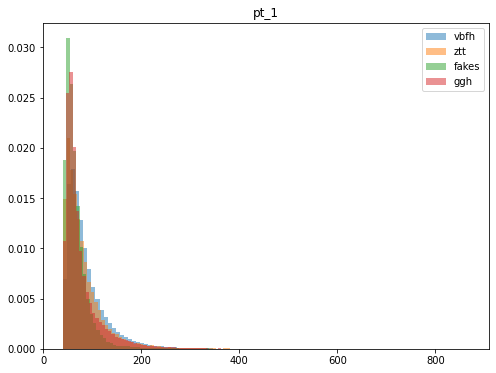

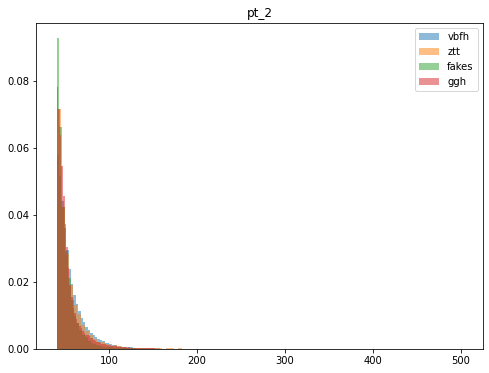

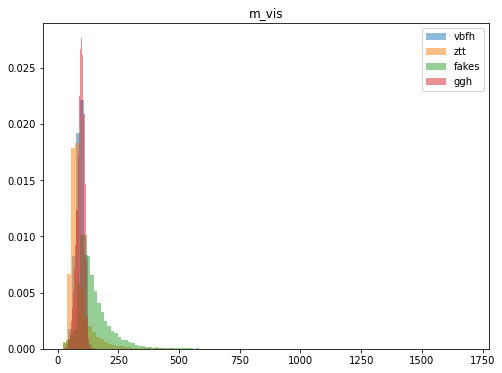

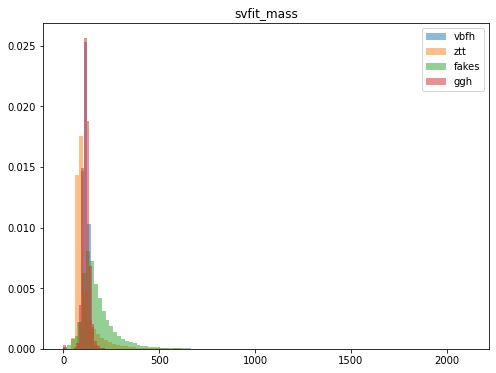

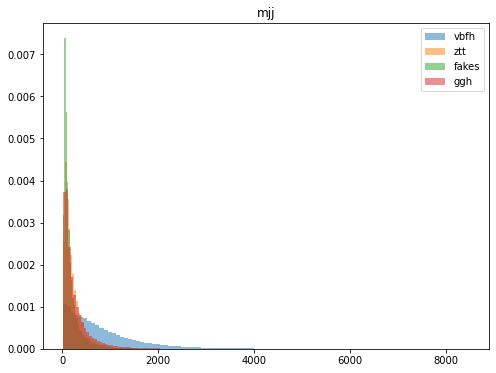

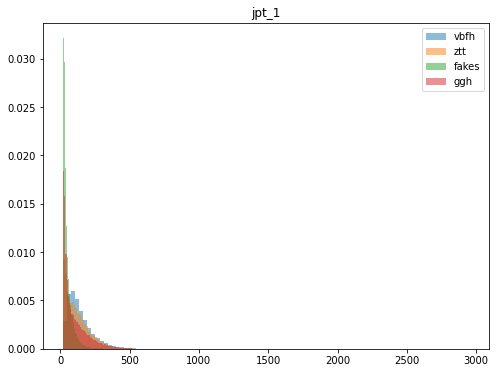

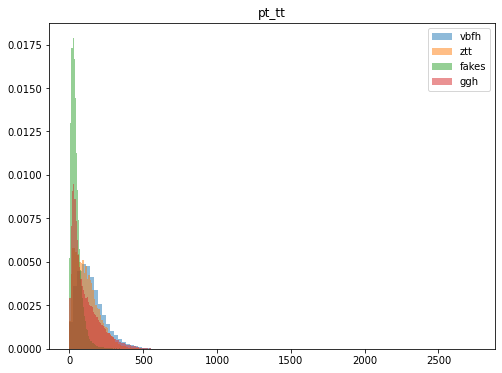

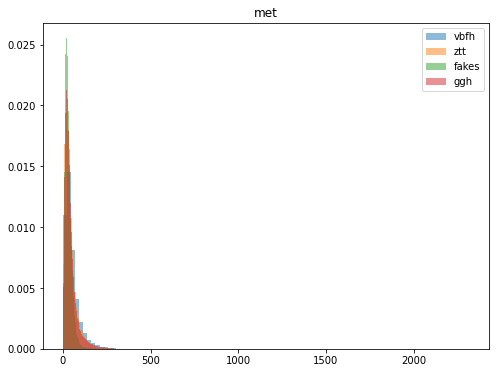

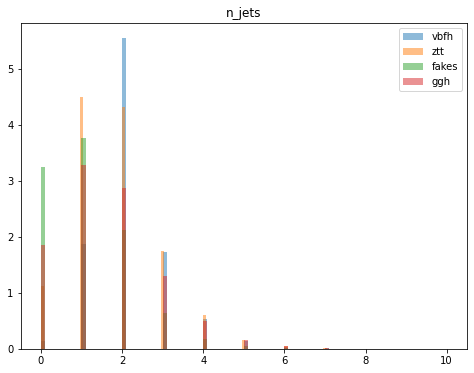

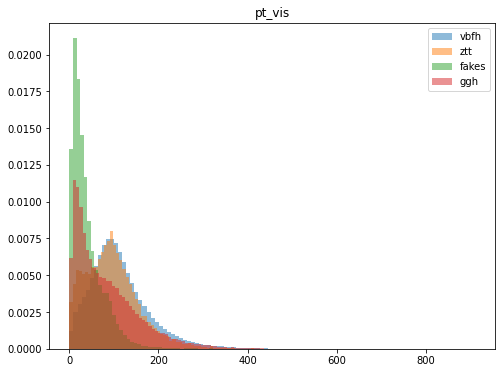

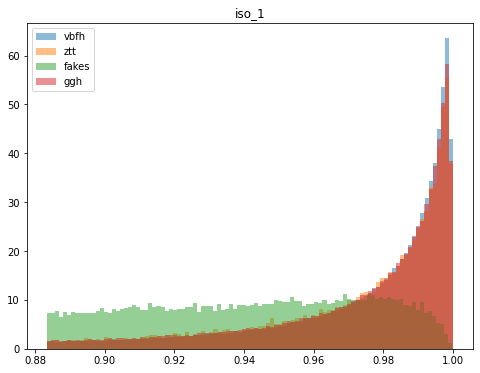

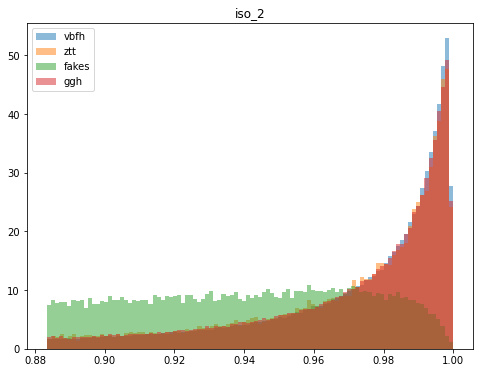

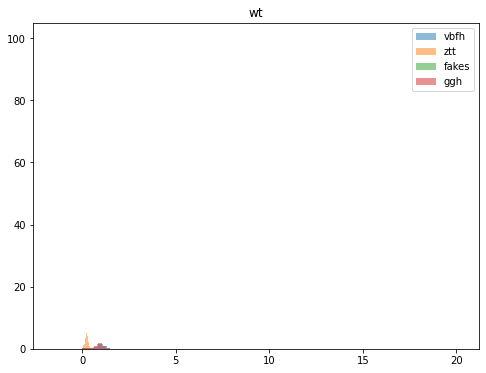

In [18]:
for var in variables:
    fig = plt.figure(figsize=(8,6))
    plt.hist(vbfh_sm[var], bins=100, alpha=0.5, density=True, label='vbfh')
    plt.hist(ztt[var], bins=100, alpha=0.5, density=True, label='ztt')
    plt.hist(fakes[var], bins=100, alpha=0.5, density=True, label='fakes')
    plt.hist(ggh_sm[var], bins=100, alpha=0.5, density=True, label='ggh')
    plt.title(var)
    plt.legend()
    #plt.savefig(f'./signal_background/eda/{var}.png')
plt.show()

In [19]:
!pip install seaborn

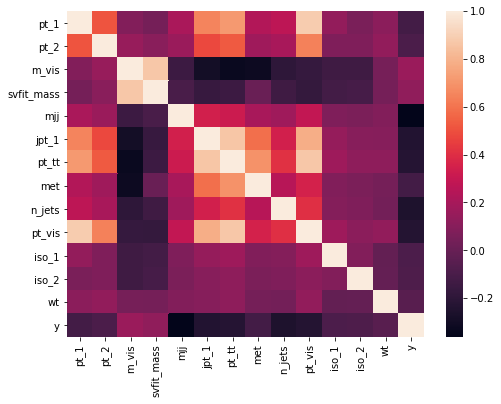

In [20]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(selectors, axis=1).corr())
plt.show()

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


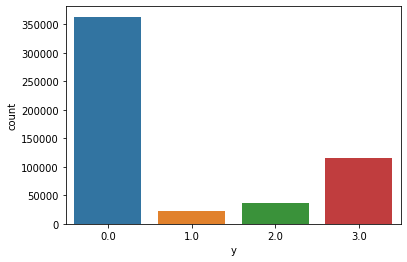

In [21]:
sns.countplot(df['y'])
#plt.savefig('./signal_background/eda/class_count.png')
plt.show()

In [22]:
# df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1) # without the iso variables
df_1 = df.drop(selectors, axis=1) # with the iso variables

In [23]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.wt
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=1, stratify=df_1.y)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [25]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [26]:
model = Sequential()
model.add(Dense(400, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
#model.add(Dense(400, activation='relu'))
#model.add(Dense(400, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [27]:
def convert_labels(arr):
    return np.argmax(arr, axis=1)

In [28]:
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.8770
Epoch 2/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5939
Epoch 3/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5798
Epoch 4/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5779
Epoch 5/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5727
Epoch 6/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5718
Epoch 7/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5722
Epoch 8/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5735
Epoch 9/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5699
Epoch 10/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5666
Epoch 11/30
13439/13439 [==============================] - 22s 2ms/step - loss: 0.5698
Epoch 12/30
13439/13439 [===========================

In [29]:
y_pred = model.predict(X_test)
y_pred_simple = convert_labels(y_pred)
y_test_simple = convert_labels(y_test)
print(accuracy_score(y_test_simple, y_pred_simple))

0.7694776202701195


In [30]:
y_pred_proba = model.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))


/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
0.8938060525340132
0.8938060525340132


In [31]:
onehot=label_binarize(y_test_simple,classes=[0,1,2,3])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred_proba[:,i])#,None,w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)

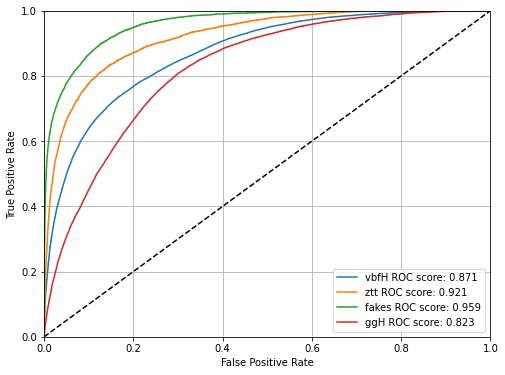

In [32]:
classes = ['vbfH', 'ztt', 'fakes', 'ggH']
fig, ax = plt.subplots(figsize=(8,6))
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
#     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
#             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    plt.legend()
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
#plt.savefig('./signal_background/eda/roc_curves.png')